In [1]:
import sys, os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem, rdBase
from rdkit.Chem import rdFMCS, Draw, PandasTools, AllChem, DataStructs, Descriptors
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import hex2color
import seaborn as sns
import time

print('RDKit version: ',rdBase.rdkitVersion)
print('Pandas version:', pd.__version__)
print('Numpy version:', np.__version__)
print('MatplotLib version:', mpl.__version__)
print('Sklearn version:', sklearn.__version__)
print('Seaborn version:', sns.__version__)

RDKit version:  2020.03.3
Pandas version: 1.0.5
Numpy version: 1.19.1
MatplotLib version: 3.3.0
Sklearn version: 0.23.2
Seaborn version: 0.10.1


In [2]:
import imp
import AutomatedSeriesClassification
imp.reload(AutomatedSeriesClassification)
from AutomatedSeriesClassification import utilsDataPrep, mainSeriesClassification, utilsDrawing

Load ChEMBL database for substructure matching (constructed during data preprocessing)

In [3]:
import pickle
chembldb = pickle.load(open('./data/chembl27_ssslib.pkl','rb'))
Nchembl = len(chembldb)

Define Parameters, note that flimit corresponds to the specificity limit E(p) as described in the paper

In [4]:
flimit=2e-3 # fig2
MinClusterSize=20 #20
proj='CDK2Kinase'
dbpath='./rdk_db'
datapath='./{0}/'.format(proj)

### UPGMA classification

Set "calcDists" to True only if the pairwise molecular distance matrix for clustering is not calculated yet (this will take a while). Set "calcScores" only if you are interested in the intra-cluster distance metric, this slows down the clustering.

In [5]:
from rdkit import DataStructs

In [6]:
#utilsDataPrep.py
#Lin32 read only 100 mols for test

UPGMAClassification=mainSeriesClassification.Classification(proj, datapath, dbpath, chembldb, flimit, MinClusterSize, clustering='UPGMA', calcDists=True, calcScores=False)

read 3187 molecules


In [7]:
from AutomatedSeriesClassification import UPGMAclustering
#imp.reload(UPGMAclustering)
#imp.reload(mainSeriesClassification)
start=time.time()
UPGMAClassification.ApplyClustering()
end=time.time()
print("Time elapsed during the calculation:", end - start)   

Time elapsed during the calculation: 1358.8229014873505


### Benchmark against human-defined classification (seriescolumn is the column with the human series assignment to each molecule in the dataframe moldata)

In [8]:
UPGMAClassification.CalculatePerformance(seriescolumn='series assignment')

In [9]:
moldata_proj=UPGMAClassification.moldata_proj
ProjectClusters=UPGMAClassification.MCSdict
PerformanceClusters=UPGMAClassification.PerformanceClusters

### Calculate performance metrics

In [10]:
Nmol=len(moldata_proj)
Nrep=sum(moldata_proj['ClusterID'].map(lambda x: len(x)).tolist())
Nunassigned=len(moldata_proj.loc[moldata_proj['ClusterID'].map(lambda x: len(x)==0)])
frac_assigned=(Nmol-Nunassigned)/Nmol
a=Nrep/(Nmol-Nunassigned)
print('fraction of assigned molecules:',frac_assigned,', ambiguity score:',a)

fraction of assigned molecules: 0.18136178224035143 , ambiguity score: 1.1903114186851211


### Plot benchmarking between automatically identified and human defined series

rearrange performance results

In [11]:
scaflist=list(set(moldata_proj['scaffold'].tolist()))
scaflist.sort()
N_auto_series=len(PerformanceClusters['recall'])
LinkVector=PerformanceClusters['linked series']

dict_recall={LinkVector[ind,0]:np.zeros(len(scaflist)) for ind in range(N_auto_series)}
dict_prec={LinkVector[ind,0]:np.zeros(len(scaflist)) for ind in range(N_auto_series)}
for ind in range(N_auto_series):
    scafind=np.where(np.array(scaflist)==LinkVector[ind,1])
    dict_recall[LinkVector[ind,0]][scafind]=PerformanceClusters['recall'][ind]
    dict_prec[LinkVector[ind,0]][scafind]=PerformanceClusters['precision'][ind]
    
keylist=LinkVector[:,0].tolist()
keylist.sort()
dict_recall_sorted={k:dict_recall[k] for k in keylist}
dict_prec_sorted={k:dict_prec[k] for k in keylist}

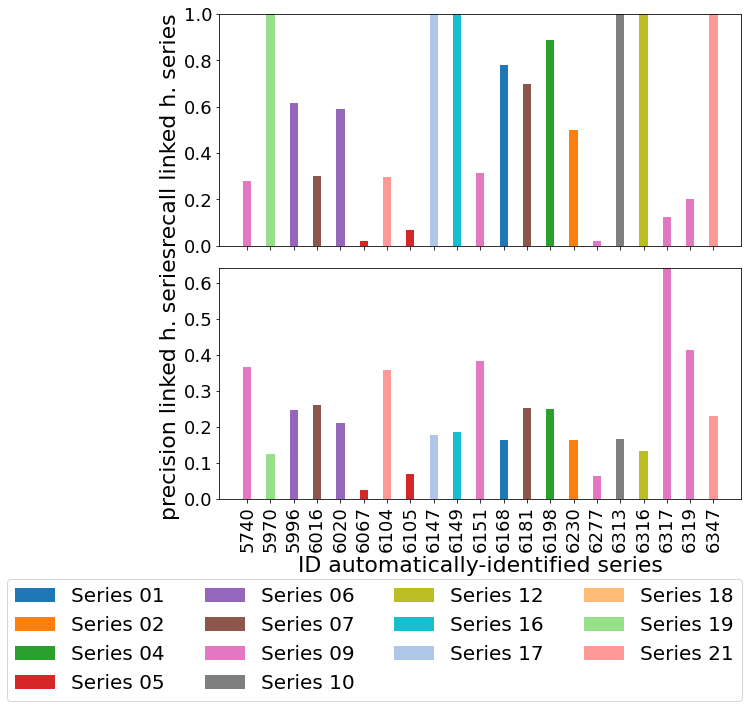

In [12]:
legend=['Series '+s[-2:] for s in scaflist]
rcParams.update({'figure.autolayout': True})
fig,ax=plt.subplots(2,1,figsize=(10,10))
fig,_=utilsDrawing.barplot_vertical(fig, ax[0],dict_recall_sorted,'recall linked h. series',[],['']*len(keylist),1.02)
fig,_=utilsDrawing.barplot_vertical(fig, ax[1],dict_prec_sorted,'precision linked h. series',legend,keylist,1.02)
ax[1].set_xlabel('ID automatically-identified series',fontsize=22)
plt.show()

### Draw MCS of automatically-identified series and linked human-defined series

In [26]:
from ipywidgets import interact,fixed,IntSlider
def renderMCS(seriesid,newscafslist,newscafsnames,linkedscafslist,linkedscafsnames):
    listid=np.where(np.array(newscafsnames)==seriesid)[0][0]
    svg_new=utilsDrawing.moltosvg(Chem.MolFromSmarts(newscafslist[listid]), molSize=(450,250))
    svg_linked=utilsDrawing.moltosvg(Chem.MolFromSmarts(linkedscafslist[listid]), molSize=(450,250))
    labels=[newscafsnames[listid],linkedscafsnames[listid]]
    svgGrid = utilsDrawing.SvgsToGrid([svg_new,svg_linked], labels=labels, svgsPerRow=2, molSize=(450,250))
    
    return(display(SVG(svgGrid)))

RDKit ERROR: [22:43:56] Aromatic bonds on non aromatic atom 8
RDKit ERROR: [22:43:56] Aromatic bonds on non aromatic atom 0
RDKit ERROR: [22:43:56] Aromatic bonds on non aromatic atom 8
RDKit ERROR: [22:43:56] Aromatic bonds on non aromatic atom 0


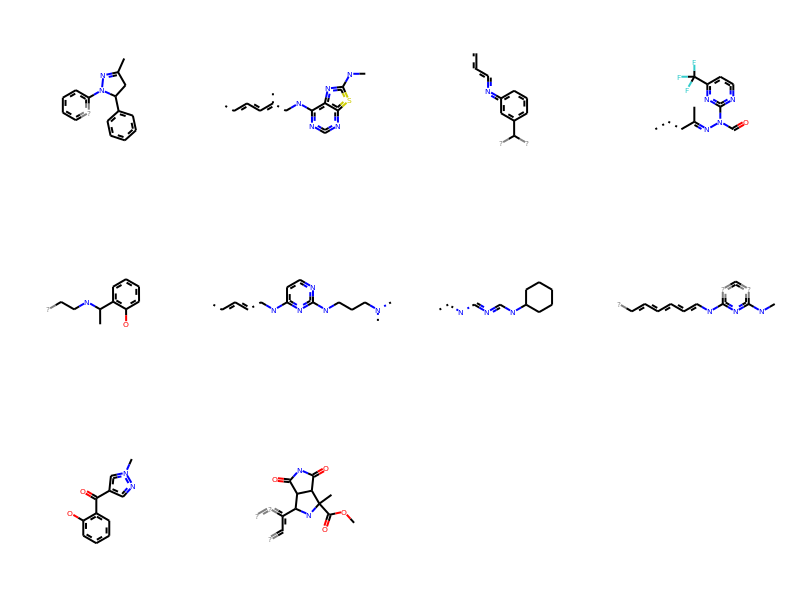

In [28]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdDepictor
rdDepictor.SetPreferCoordGen(True)
scafs = [Chem.MolFromSmarts(scaf) for scaf in MCSlist[:10]]
Draw.MolsToGridImage(scafs, molsPerRow=4)

In [14]:
seriesdata_proj=pd.read_csv('{0}seriesdata.csv'.format(datapath))
LinkVector_sorted=np.array([[x,y] for x,y in sorted(zip(LinkVector[:,0],LinkVector[:,1]))])
linkedScafsList=[seriesdata_proj['MCSsampled'].loc[seriesdata_proj['ScafName']==x].iloc[0] for x in LinkVector_sorted[:,1]]
linkedScafsNames=[x for x in LinkVector_sorted[:,1]]
MCSlist=[ProjectClusters[int(k)][2] for k in keylist]

interact(renderMCS, seriesid=keylist, newscafslist=fixed(MCSlist),newscafsnames=fixed(keylist),linkedscafslist=fixed(linkedScafsList),linkedscafsnames=fixed(linkedScafsNames));


interactive(children=(Dropdown(description='seriesid', options=('5740', '5970', '5996', '6016', '6020', '6067'…

### 10fold cross-validation by sampling 40% of all compounds

In [29]:
fraction_sample=0.4
N_sample=10
start=time.clock()
UPGMAClassification.ClassificationCrossValidation(fraction_sample, N_sample)
end=time.clock()
print("Time elapsed during the calculation:", end - start)   

/home/iwatobipen/miniconda3/envs/chemoinfo/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Time elapsed during the calculation: 106945.051047


/home/iwatobipen/miniconda3/envs/chemoinfo/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [30]:
UPGMAClassification.EvaluationCrossValidation()

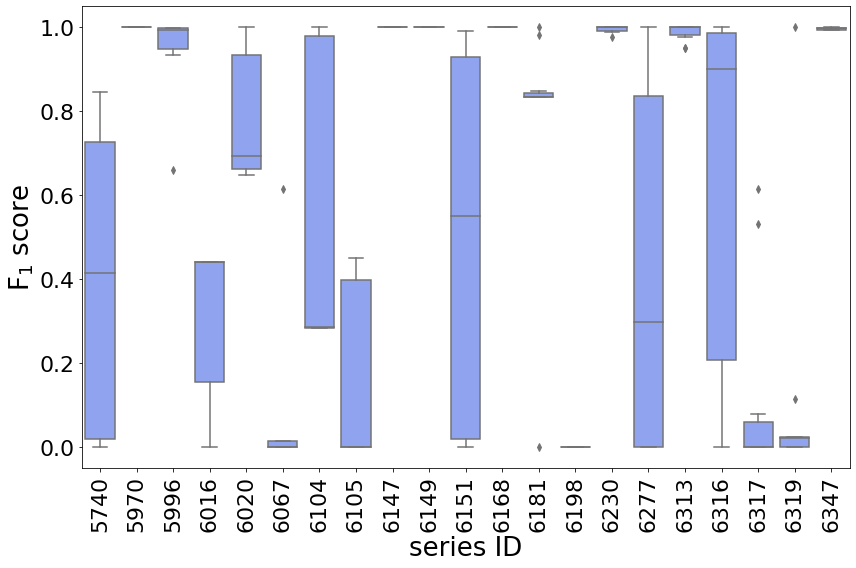

In [31]:
rcParams.update({'figure.autolayout': True})
fig,ax=plt.subplots(1,1,figsize=(12,8))
ax = sns.boxplot(x="series id", y="fscore", data=UPGMAClassification.EvalCrossval, color=[0.5,0.6,1.0],ax=ax)
ax.set_ylabel('F$_1$ score',fontsize=26)
ax.set_xlabel('series ID',fontsize=26)

plt.setp(ax.get_xticklabels(), fontsize=22, rotation='vertical')
plt.setp(ax.get_yticklabels(), fontsize=22)
plt.show()